## Helper functions

In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [3]:
# Removes from X the specified features
def rm_feature(X, omitted_features):
    X = X.drop(columns=omitted_features)
    return X

In [4]:
def get_categorical_features(X):
    column_types = X.dtypes
    categorical_features = column_types[column_types == 'object'].index.tolist()
    return categorical_features


In [5]:
def one_hot_encoding(X, categorical_features):
    X_one_hot = pd.get_dummies(X, columns=categorical_features,dtype=int)
    return X_one_hot


In [6]:
class FeatureSelector():
    def __init__(self, cv_size = 10, take_logs = True):
        self.k_fold_splitter = KFold(n_splits=cv_size, random_state=1,
                                     shuffle=True)

        self.take_logs = take_logs


    def rmsle(self, y, y_pred, **kwargs):
        y_true = y
        if self.take_logs:
            y_true = np.exp(y) - 1
            y_pred = np.exp(y_pred) - 1
        y_pred = np.maximum(0, y_pred)
        return np.sqrt(np.mean((np.log(1 + y_true) - np.log(1 + y_pred))**2))

    def stepwise_feature_selection(self, X, y, estimator, forward,
                                   n_features_to_select = 10,
                                   score_function = 'auto'):

        if score_function == 'auto':
            score_func = make_scorer(self.rmsle, greater_is_better=False)
        else:
            score_func = score_function

        sfs = SFS(
            estimator,
            k_features = n_features_to_select,
            forward=forward,
            floating=False,
            scoring = score_func,
            cv=self.k_fold_splitter,
            n_jobs=-1
        )
        y_to_fit = np.log(y+1) if self.take_logs else y
        sfs.fit(X, y_to_fit)
        return sfs

    def k_fold_cv(self, model, X, y):
        score_function = make_scorer(self.rmsle)
        y_to_fit = np.log(y+1) if self.take_logs else y
        scores = cross_val_score(model,
            X,
            y_to_fit,
            scoring = score_function,
            cv = self.k_fold_splitter,
            n_jobs = -1)
        return np.mean(scores)


    def select_best_subset(self, X, y, estimator, forward,
                           n_features_to_select = 10,
                           score_function = 'auto'):
        sfs = self.stepwise_feature_selection(X, y,
                                              estimator,
                                              forward,
                                              n_features_to_select,
                                              score_function)
        subsets = sfs.subsets_
        best_subset = max(subsets.values(), key = lambda x: x['avg_score'])
        return list(best_subset['feature_idx']), best_subset['avg_score']


    def grid_search(self, X, y, model, params, score_function='auto'):
        if score_function == 'auto':
            score_func = make_scorer(self.rmsle, greater_is_better=False)
        else:
            score_func = score_function

        grid = GridSearchCV(
            model,
            params,
            scoring = score_func,
            n_jobs = -1,
            cv = self.k_fold_splitter
        )
        y_to_fit = np.log(y+1) if self.take_logs else y
        grid.fit(X, y_to_fit)
        return grid

## Test

In [8]:
train = pd.read_csv("phone_train.csv")
test = pd.read_csv("phone_validation.csv")

# Encode train and test sets
X_train = rm_feature(train, ['y'])
y_train = train['y']
X_test = test

In [9]:
cat_features = get_categorical_features(X_train)
cat_features = cat_features + ['activation.zone', 'activation.channel',
                               'tariff.plan']
cat_features

['payment.method',
 'sex',
 'vas1',
 'vas2',
 'activation.zone',
 'activation.channel',
 'tariff.plan']

In [10]:
X_train['label'] = 'train'
X_test['label'] = 'test'

concat_X = pd.concat([X_train, X_test])
concat_X = one_hot_encoding(concat_X, cat_features + ['label'])

X_train = concat_X[concat_X['label_train']==1]
X_test = concat_X[concat_X['label_test']==1]

X_train = X_train.drop(['label_train','label_test'], axis=1)
X_test = X_test.drop(['label_train','label_test'], axis=1)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Columns: 119 entries, age to tariff.plan_8
dtypes: float64(19), int64(100)
memory usage: 9.2 MB


### Forward stepwise selection

In [ ]:
model = LinearRegression()
feature_selector = FeatureSelector()
sfs = feature_selector.stepwise_feature_selection(X_train, y_train, model, True,
                                 n_features_to_select="best")
X_train_sfs = sfs.transform(X_train)

In [ ]:
X_train[list(sfs.k_feature_names_)]

,age,q01.out.ch.peak,q01.out.ch.offpeak,q01.out.val.offpeak,q01.in.dur.tot,q01.ch.sms,q02.out.ch.peak,q02.ch.sms,q03.out.dur.offpeak,q03.in.ch.tot,...,vas1_Y,vas2_N,vas2_Y,activation.zone_0,activation.zone_2,activation.channel_8,activation.channel_9,tariff.plan_3,tariff.plan_4,tariff.plan_8
0,34.29,82,0,0.0000,4154,6,70,0,0,78,...,0,1,0,0,0,0,0,0,0,0
1,22.78,0,0,0.0000,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
2,26.95,244,0,0.0000,16351,0,392,2,0,263,...,1,1,0,0,0,0,0,0,0,0
3,46.09,331,0,0.0000,41517,0,303,0,0,499,...,1,1,0,0,1,0,0,0,0,0
4,23.77,0,0,0.0000,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,23.01,0,0,0.0000,0,0,0,0,0,13,...,0,1,0,0,1,0,0,0,0,1
9996,44.72,24,6,2.3788,1113,0,13,0,153,17,...,0,1,0,0,1,0,0,0,0,0
9997,17.47,0,0,0.0000,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
9998,21.67,0,0,0.0000,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1


In [ ]:
# Test model with subset features
feature_selector.k_fold_cv(LinearRegression(), X_train_sfs, y_train)

2.432767864867283

In [ ]:
# Test model with all features
feature_selector.k_fold_cv(LinearRegression(), X_train, y_train)

2.463238898092651

### Prediction on X_test

In [ ]:
X_test_sfs = sfs.transform(X_test)

In [ ]:
model = LinearRegression()
model.fit(X_train_sfs, np.log(y_train + 1))
y_pred = np.exp(model.predict(X_test_sfs)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission.txt', index=False, header=False, sep='\t')

## KNN regression

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor as KNN

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNN(n_neighbors = 10))])

feature_selector = FeatureSelector()

sfs_knn = feature_selector.stepwise_feature_selection(X_train, y_train,
                                                      pipe, True,
                                                      n_features_to_select=10)

In [ ]:
X_train[list(sfs_knn.k_feature_names_)]

,q08.out.ch.peak,q09.out.ch.peak,q09.out.ch.offpeak,q09.out.dur.offpeak,q09.out.val.offpeak,q09.ch.sms,vas2_N,vas2_Y,activation.zone_0,tariff.plan_3
0,70,77,0,0,0.0,0,1,0,0,0
1,23,16,0,0,0.0,1,1,0,0,0
2,131,343,0,0,0.0,0,1,0,0,0
3,167,261,0,0,0.0,0,1,0,0,0
4,0,0,0,0,0.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,16,5,0,0,0.0,4,1,0,0,0
9996,21,83,0,0,0.0,0,1,0,0,0
9997,0,9,0,0,0.0,0,0,1,0,0
9998,24,32,0,0,0.0,38,1,0,0,0


In [ ]:
X_train_sfs_knn = sfs_knn.transform(X_train)
feature_selector.k_fold_cv(pipe, X_train_sfs_knn, y_train)

2.085578338894409

In [ ]:
X_test_sfs_knn = sfs_knn.transform(X_test)

In [ ]:
pipe.fit(X_train_sfs_knn, np.log(y_train + 1))
y_pred = np.exp(pipe.predict(X_test_sfs_knn)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission_knn.txt', index=False, header=False, sep='\t')

## Principal Component Regression (PCR)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pcr = LinearRegression()
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
feature_selector = FeatureSelector()
X_train_pca = pca.fit_transform(X_train)

sfs_pcr = feature_selector.stepwise_feature_selection(X_train_pca, y_train,
                                                      pcr, True,
                                                      n_features_to_select="best")

In [ ]:
X_train_sfs_pcr = sfs_pcr.transform(X_train_pca)
X_train_sfs_pcr.shape

(10000, 55)

In [ ]:
feature_selector.k_fold_cv(pcr, X_train_sfs_pcr, y_train)

2.4365161551083765

## KNN best subsets

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', KNN(n_neighbors = 10))])

feature_selector = FeatureSelector()

best_features ,score = feature_selector.select_best_subset(X_train, y_train,
                                                      pipe, True,
                                                      n_features_to_select=15)
print(score)

-2.095635284041081


In [ ]:
X_train_best_knn = X_train[X_train.columns[best_features]]
X_train_best_knn

,q08.out.dur.offpeak,q08.out.val.offpeak,q09.out.ch.peak,q09.out.ch.offpeak,q09.out.val.offpeak,activation.channel_4,tariff.plan_3,tariff.plan_4
0,0,0.0,77,0,0.0,0,0,0
1,0,0.0,16,0,0.0,0,0,0
2,0,0.0,343,0,0.0,0,0,0
3,0,0.0,261,0,0.0,0,0,0
4,0,0.0,0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...
9995,0,0.0,5,0,0.0,0,0,0
9996,0,0.0,83,0,0.0,0,0,0
9997,0,0.0,9,0,0.0,0,0,0
9998,0,0.0,32,0,0.0,0,0,0


In [ ]:
feature_selector.k_fold_cv(pipe, X_train_best_knn, y_train)

2.0954284162249515

In [ ]:
X_test_best_knn = X_test[X_test.columns[best_features]]

In [ ]:
pipe.fit(X_train_best_knn, np.log(y_train + 1))
y_pred = np.exp(pipe.predict(X_test_best_knn)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission_knn_best_subset.txt', index=False, header=False, sep='\t')

## Most correlated features

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class GetTopCorrFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=5):
      self.top_n = top_n

    def fit(self, X, y = None):
        X = pd.DataFrame(X)
        corr = np.array(X.apply(lambda x: x.corr(y)))
        corr_indexes = np.argsort(abs(corr))[::-1]
        self.top_corr_indexes = corr_indexes[0:self.top_n]
        return self

    def transform(self, X):
        X = np.array(X)
        X = X[:,self.top_corr_indexes]
        return X

### KNN

In [ ]:
# Try to perform KNN regression, considering only the top correlated features with 'y'
feature_selector = FeatureSelector()
pipe = Pipeline([('fs', GetTopCorrFeatures()), ('scaler', StandardScaler()),
                 ('model', KNN())])

params = {
    'fs__top_n' : range(5, 50, 5),
    'model__n_neighbors': range(5, 100, 5)
}

grid = feature_selector.grid_search(X_train, y_train, pipe, params)
grid.best_params_

{'fs__top_n': 10, 'model__n_neighbors': 30}

In [ ]:
results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
results.to_csv('results-gridSearch-gb-fs.csv')
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fs__top_n,param_model__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
24,0.217232,0.046278,0.163569,0.037581,10,30,"{'fs__top_n': 10, 'model__n_neighbors': 30}",-2.241824,-2.278478,-2.367676,-2.230590,-2.410236,-2.359430,-2.330620,-2.339857,-2.333953,-2.368097,-2.326076,0.055178,1
26,0.134676,0.013344,0.110705,0.008640,10,40,"{'fs__top_n': 10, 'model__n_neighbors': 40}",-2.236056,-2.286560,-2.367683,-2.231347,-2.415247,-2.346402,-2.339495,-2.337238,-2.332553,-2.375808,-2.326839,0.056168,2
27,0.137689,0.014760,0.107358,0.006553,10,45,"{'fs__top_n': 10, 'model__n_neighbors': 45}",-2.234575,-2.285464,-2.360999,-2.228806,-2.414194,-2.340885,-2.344364,-2.337269,-2.344334,-2.383806,-2.327470,0.057266,3
25,0.145660,0.009063,0.096788,0.007234,10,35,"{'fs__top_n': 10, 'model__n_neighbors': 35}",-2.240031,-2.286267,-2.369258,-2.232379,-2.417918,-2.350062,-2.337666,-2.339220,-2.333859,-2.376095,-2.328276,0.056093,4
28,0.133966,0.019543,0.119539,0.012341,10,50,"{'fs__top_n': 10, 'model__n_neighbors': 50}",-2.236852,-2.286564,-2.354467,-2.233153,-2.418967,-2.344696,-2.345749,-2.336647,-2.348586,-2.384655,-2.329034,0.056822,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0.121029,0.013093,0.095392,0.013631,20,5,"{'fs__top_n': 20, 'model__n_neighbors': 5}",-2.354974,-2.511834,-2.507626,-2.396056,-2.531083,-2.491268,-2.542956,-2.530650,-2.513436,-2.561114,-2.494100,0.062793,167
95,0.120594,0.010715,0.101356,0.010154,30,5,"{'fs__top_n': 30, 'model__n_neighbors': 5}",-2.381826,-2.478393,-2.523613,-2.398658,-2.539983,-2.545097,-2.497915,-2.529456,-2.530924,-2.586684,-2.501255,0.061821,168
133,0.116188,0.011406,0.122458,0.013009,40,5,"{'fs__top_n': 40, 'model__n_neighbors': 5}",-2.432330,-2.533983,-2.483237,-2.500013,-2.525391,-2.543486,-2.494819,-2.491859,-2.458939,-2.587110,-2.505117,0.042019,169
152,0.122880,0.014121,0.117091,0.013244,45,5,"{'fs__top_n': 45, 'model__n_neighbors': 5}",-2.427566,-2.544788,-2.461607,-2.495968,-2.490588,-2.519530,-2.518544,-2.547706,-2.467806,-2.581595,-2.505570,0.043837,170


### SVM

In [ ]:
from sklearn.svm import SVR

In [ ]:
feature_selector = FeatureSelector()
pipe = Pipeline([('fs', GetTopCorrFeatures()), ('scaler', StandardScaler()),
                 ('model', SVR(kernel = 'rbf'))])

params = {
    'fs__top_n' : range(5, 50, 5)
}

grid = feature_selector.grid_search(X_train, y_train, pipe, params)
grid.best_params_

{'fs__top_n': 40}

In [ ]:
results = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
results.to_csv('results-gridSearch-svm-fs.csv')
display(results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fs__top_n,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
7,8.999977,0.583695,1.247074,0.208144,40,{'fs__top_n': 40},-2.273457,-2.402566,-2.356462,-2.304394,-2.474900,-2.371519,-2.436454,-2.354681,-2.402058,-2.433952,-2.381044,0.058671,1
8,9.778252,0.583817,1.339035,0.338415,45,{'fs__top_n': 45},-2.286699,-2.414169,-2.365865,-2.310935,-2.484477,-2.374624,-2.446621,-2.366225,-2.417946,-2.454873,-2.392243,0.059968,2
1,7.430744,0.659334,1.041959,0.278830,10,{'fs__top_n': 10},-2.234786,-2.330802,-2.370112,-2.298632,-2.514940,-2.403132,-2.490694,-2.404390,-2.453583,-2.472761,-2.397383,0.085332,3
2,8.356482,0.607188,1.180319,0.265866,15,{'fs__top_n': 15},-2.251380,-2.352538,-2.358349,-2.316814,-2.544556,-2.416375,-2.490031,-2.410352,-2.467949,-2.475034,-2.408338,0.084808,4
3,7.746602,0.563490,1.114494,0.226941,20,{'fs__top_n': 20},-2.259237,-2.379324,-2.378650,-2.318958,-2.553016,-2.440428,-2.479442,-2.411134,-2.478168,-2.471742,-2.417010,0.081922,5
4,8.486744,0.565549,1.320558,0.335555,25,{'fs__top_n': 25},-2.273979,-2.392931,-2.392664,-2.326638,-2.565860,-2.448390,-2.487587,-2.414508,-2.487607,-2.488908,-2.427907,0.081787,6
6,8.394913,0.576934,1.129990,0.147500,35,{'fs__top_n': 35},-2.305007,-2.398038,-2.340324,-2.299164,-2.575799,-2.455512,-2.514056,-2.415048,-2.495927,-2.514567,-2.431344,0.090820,7
5,9.458037,0.526427,1.323209,0.296854,30,{'fs__top_n': 30},-2.294360,-2.402815,-2.400913,-2.333056,-2.573293,-2.455553,-2.500565,-2.414574,-2.488303,-2.503497,-2.436693,0.080086,8
0,6.641044,0.680220,0.773785,0.009006,5,{'fs__top_n': 5},-2.298634,-2.330818,-2.382702,-2.319429,-2.568018,-2.474544,-2.539101,-2.479205,-2.534949,-2.525790,-2.445319,0.097344,9


## Ridge Regression

In [18]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [47]:
ridge = Ridge()
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0]
params = {
    "alpha": alphas
}
feature_selector = FeatureSelector()

In [48]:
grid = feature_selector.grid_search(X_train, y_train, ridge, params)

In [49]:
best_alpha = grid.best_params_['alpha']
print(best_alpha)

20.0


In [50]:
results = pd.DataFrame(grid.cv_results_)
results_sorted = results.sort_values(by='rank_test_score')
results_sorted.to_csv('results-gridSearch-ridge.csv')
display(results_sorted)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
6,0.051713,0.014157,0.008486,0.001155,20.0,{'alpha': 20.0},-2.470914,-2.444705,-2.394594,-2.477751,-2.399330,-2.389020,-2.521104,-2.478053,-2.523567,-2.529925,-2.462896,0.051547,1
7,0.056571,0.015472,0.008437,0.000831,30.0,{'alpha': 30.0},-2.471279,-2.444874,-2.394379,-2.476847,-2.399686,-2.389663,-2.520665,-2.478005,-2.523606,-2.530165,-2.462917,0.051400,2
5,0.054034,0.014960,0.008326,0.001521,10.0,{'alpha': 10.0},-2.470572,-2.444505,-2.395004,-2.478884,-2.399060,-2.388420,-2.521898,-2.478196,-2.523610,-2.529683,-2.462983,0.051716,3
8,0.060888,0.019878,0.009798,0.003418,40.0,{'alpha': 40.0},-2.471654,-2.445021,-2.394302,-2.476117,-2.400095,-2.390323,-2.520473,-2.478021,-2.523709,-2.530394,-2.463011,0.051269,4
4,0.052988,0.013275,0.008150,0.000904,5.0,{'alpha': 5.0},-2.470415,-2.444391,-2.395309,-2.479564,-2.398976,-2.388151,-2.522477,-2.478320,-2.523668,-2.529569,-2.463084,0.051811,5
9,0.060205,0.019989,0.012374,0.007375,50.0,{'alpha': 50.0},-2.472034,-2.445153,-2.394327,-2.475520,-2.400542,-2.390989,-2.520463,-2.478083,-2.523866,-2.530610,-2.463159,0.051151,6
3,0.054156,0.015625,0.008869,0.001219,2.0,{'alpha': 2.0},-2.470329,-2.444316,-2.395534,-2.480015,-2.398951,-2.388007,-2.522899,-2.478419,-2.523717,-2.529509,-2.463169,0.051871,7
2,0.057521,0.014748,0.008919,0.002942,1.0,{'alpha': 1.0},-2.470301,-2.444290,-2.395616,-2.480174,-2.398948,-2.387962,-2.523054,-2.478456,-2.523735,-2.529491,-2.463203,0.051891,8
1,0.056598,0.016502,0.008022,0.000446,0.5,{'alpha': 0.5},-2.470288,-2.444277,-2.395659,-2.480255,-2.398947,-2.387941,-2.523135,-2.478476,-2.523745,-2.529482,-2.463221,0.051902,9
0,0.049743,0.013840,0.008199,0.001011,0.1,{'alpha': 0.1},-2.470278,-2.444266,-2.395695,-2.480321,-2.398948,-2.387924,-2.523200,-2.478492,-2.523753,-2.529475,-2.463235,0.051910,10


In [51]:
errors = results[["mean_test_score"]].to_numpy()

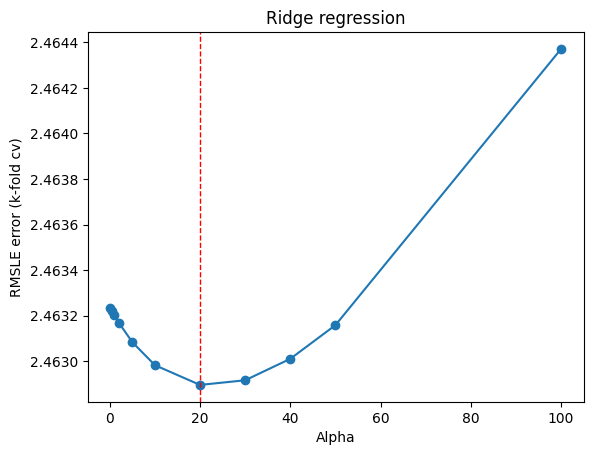

In [52]:
plt.plot(alphas, -errors, marker='o')
plt.axvline(x=best_alpha, color='r', linestyle='--', linewidth=1)

# Add a title and labels
plt.title('Ridge regression')
plt.xlabel('Alpha')
plt.ylabel('RMSLE error (k-fold cv)')

# Show the plot
plt.show()

## Lasso

In [58]:
from sklearn.linear_model import Lasso

In [66]:
lasso = Lasso()
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 100.0]
params = {
    "alpha": alphas
}
feature_selector = FeatureSelector()

In [67]:
grid = feature_selector.grid_search(X_train, y_train, lasso, params)

In [68]:
best_alpha = grid.best_params_['alpha']
print(best_alpha)

0.1


In [69]:
results = pd.DataFrame(grid.cv_results_)
results_sorted = results.sort_values(by='rank_test_score')
results_sorted.to_csv('results-gridSearch-ridge.csv')
display(results_sorted)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.307514,1.404875,0.014200,0.005053,0.1,{'alpha': 0.1},-2.511373,-2.487023,-2.430713,-2.505379,-2.451139,-2.470401,-2.591070,-2.511931,-2.533608,-2.579672,-2.507231,0.048766,1
1,0.977932,0.246751,0.009590,0.001989,0.5,{'alpha': 0.5},-2.589872,-2.547247,-2.497400,-2.605219,-2.548866,-2.576449,-2.706316,-2.599235,-2.616108,-2.661938,-2.594865,0.056342,2
2,0.530367,0.121017,0.011347,0.004897,1.0,{'alpha': 1.0},-2.596912,-2.547189,-2.510259,-2.625819,-2.552503,-2.586961,-2.704934,-2.614507,-2.611445,-2.658704,-2.600923,0.053605,3
3,0.239557,0.028340,0.011470,0.005123,2.0,{'alpha': 2.0},-2.623060,-2.555151,-2.540708,-2.682568,-2.577031,-2.609240,-2.708073,-2.647661,-2.617374,-2.666286,-2.622715,0.051939,4
4,0.281747,0.039983,0.014783,0.006723,5.0,{'alpha': 5.0},-2.681363,-2.584496,-2.605150,-2.732959,-2.651390,-2.672079,-2.756803,-2.708876,-2.666458,-2.711772,-2.677135,0.051239,5
5,0.249186,0.065695,0.019094,0.006370,10.0,{'alpha': 10.0},-2.723076,-2.621383,-2.651562,-2.773612,-2.699938,-2.718403,-2.806427,-2.747386,-2.708988,-2.752967,-2.720374,0.052081,6
6,0.267905,0.050287,0.015245,0.004025,20.0,{'alpha': 20.0},-2.736261,-2.635281,-2.668808,-2.771634,-2.713468,-2.734114,-2.836594,-2.750676,-2.721449,-2.768995,-2.733728,0.052937,7
7,0.134267,0.023682,0.007968,0.001321,30.0,{'alpha': 30.0},-2.758066,-2.655128,-2.692018,-2.775242,-2.731479,-2.754119,-2.875582,-2.764508,-2.739281,-2.788859,-2.753428,0.055600,8
10,0.093446,0.011770,0.008680,0.004275,100.0,{'alpha': 100.0},-2.775925,-2.679108,-2.712756,-2.774471,-2.752217,-2.770672,-2.893187,-2.782775,-2.761040,-2.812584,-2.771473,0.053963,9
9,0.109675,0.010356,0.007853,0.001255,50.0,{'alpha': 50.0},-2.777994,-2.676150,-2.712916,-2.781202,-2.750303,-2.772163,-2.896776,-2.782798,-2.759036,-2.808491,-2.771783,0.055185,10


In [70]:
errors = results[["mean_test_score"]].to_numpy()

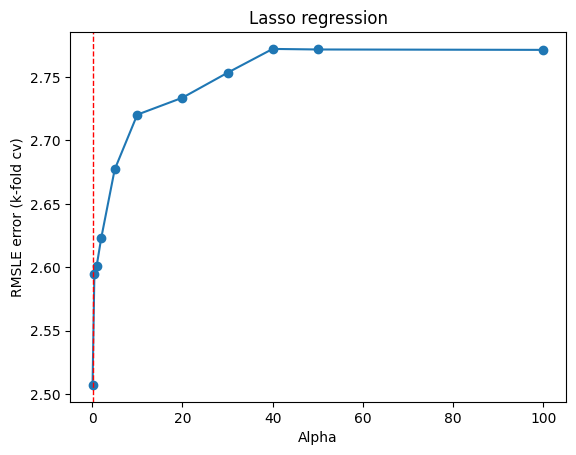

In [72]:
plt.plot(alphas, -errors, marker='o')
plt.axvline(x=best_alpha, color='r', linestyle='--', linewidth=1)

# Add a title and labels
plt.title('Lasso regression')
plt.xlabel('Alpha')
plt.ylabel('RMSLE error (k-fold cv)')

# Show the plot
plt.show()

In [73]:
lasso = Lasso(alpha = best_alpha)
feature_selector.k_fold_cv(lasso, X_train, y_train)

2.5072308204051055

## Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
def metric(y_true, y_pred):
    y_true = np.exp(y_true) - 1
    y_pred = np.exp(y_pred) - 1
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(np.mean((np.log(1 + y_true) - np.log(1 + y_pred))**2))


In [76]:
min_estimators = 50
max_estimators = 250
oob_scores = []
RANDOM_STATE = 123
random_forest = RandomForestRegressor(max_features="sqrt",
                                      oob_score=metric,
                                      random_state=RANDOM_STATE)

y_to_fit = np.log(y_train + 1)
for i in range(min_estimators, max_estimators + 1, 5):
    random_forest.set_params(n_estimators=i)
    random_forest.fit(X_train, y_to_fit)
    oob_score = random_forest.oob_score_
    oob_scores.append( (i, oob_score) )
    print(f"n_estimators = {i}, oob_score = {oob_score}")

n_estimators = 50, oob_score = 4.168005484843197
n_estimators = 55, oob_score = 4.164762222350007
n_estimators = 60, oob_score = 4.161290856829163
n_estimators = 65, oob_score = 4.159585312612759
n_estimators = 70, oob_score = 4.156333522302979
n_estimators = 75, oob_score = 4.1555180666496465
n_estimators = 80, oob_score = 4.154711819282099
n_estimators = 85, oob_score = 4.153029590752037
n_estimators = 90, oob_score = 4.151512584007922
n_estimators = 95, oob_score = 4.151003633549774
n_estimators = 100, oob_score = 4.149684040109426
n_estimators = 105, oob_score = 4.149601797498359
n_estimators = 110, oob_score = 4.14932339993671
n_estimators = 115, oob_score = 4.149645875438962
n_estimators = 120, oob_score = 4.14986933072874
n_estimators = 125, oob_score = 4.1493800008129105
n_estimators = 130, oob_score = 4.148756141682475
n_estimators = 135, oob_score = 4.148377662136725
n_estimators = 140, oob_score = 4.148564468471907
n_estimators = 145, oob_score = 4.148386433435
n_estimators 

In [77]:
best_oob_score = min(oob_scores, key = lambda x: x[1])
print(best_oob_score)
best_n_estimator = best_oob_score[0]

(195, 4.146696670854489)


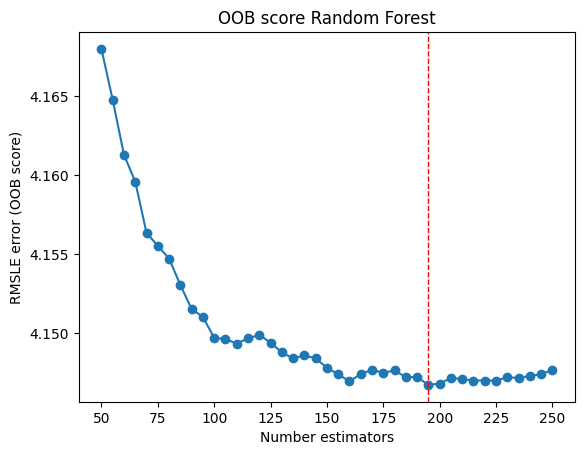

In [79]:
n_estimators = range(min_estimators, max_estimators + 1, 5)
plotted_scores = [oob_score[1] for oob_score in oob_scores]

plt.plot(n_estimators, plotted_scores, marker='o')
plt.axvline(x=best_n_estimator, color='r', linestyle='--', linewidth=1)

# Add a title and labels
plt.title('OOB score Random Forest')
plt.xlabel('Number estimators')
plt.ylabel('RMSLE error (OOB score)')

# Show the plot
plt.show()

In [80]:
model = random_forest = RandomForestRegressor(max_features="sqrt",
                                      oob_score=True,
                                      random_state=RANDOM_STATE,
                                      n_estimators = best_n_estimator)
feature_selector = FeatureSelector(take_logs=True)

In [81]:
feature_selector.k_fold_cv(model, X_train, y_train)

1.9941631472498802

In [ ]:
model.fit(X_train, np.log(y_train + 1))
y_pred = np.exp(model.predict(X_test)) - 1
y_pred = np.maximum(0, y_pred)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv('mySubmission_random_forest_oob.txt', index=False, header=False, sep='\t')

## TODO:
- Analyse residuals
- Perform EDA
- Try grid search with random forest
- Try gradient boosting taking logs of y